In [1]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import bokeh

# in your notebook cell
import sys

# path relative to your notebook
sys.path.insert(0, '../src')

# import as usual
import functions

# autoreload
%load_ext autoreload
%autoreload 2

#defining DataFrame
df = functions.read_file('../data/PIRUS_March2023/PIRUS_V4.xlsx')


import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, auc
import numpy as np
#from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
df.shape

(3203, 130)

## Cleaning Data

In [3]:
#Checking different columns against the different populations (violent/non-violent/military/non-military)

print("Non Violent Mil:\n", df[(df["Military"] == 1) & (df["Violent"] == 0)].groupby(["Internet_Radicalization"]).size().sort_values(ascending=False))
print("\nViolent Mil:\n", df[(df["Military"] == 1) & (df["Violent"] == 1)].groupby(["Internet_Radicalization"]).size().sort_values(ascending=False))
print("\nNon Violent Civ:\n", df[(df["Military"] == 0) & (df["Violent"] == 0)].groupby(["Internet_Radicalization"]).size().sort_values(ascending=False))
print("\nViolent Civ:\n", df[(df["Military"] == 0) & (df["Violent"] == 1)].groupby(["Internet_Radicalization"]).size().sort_values(ascending=False))

# print(df["Social_Stratum_Adulthood"].value_counts())

Non Violent Mil:
 Internet_Radicalization
 1     78
-99    41
-88    39
 2      7
 0      6
dtype: int64

Violent Mil:
 Internet_Radicalization
 1     118
-99     74
-88     52
 2      40
 0      15
dtype: int64

Non Violent Civ:
 Internet_Radicalization
 1     332
-99    275
-88    135
 2      63
 0      39
dtype: int64

Violent Civ:
 Internet_Radicalization
 1     454
-99    393
-88    186
 2     154
 0      67
dtype: int64


In [4]:
# df.head()

df["Time_US_Months"].dtype

dtype('int64')

In [5]:
saved_cols = ['Subject_ID', 'Year_Exposure',
       'Violent','Foreign_Fighter', 'Group_Membership', 'Actively_Recruited', 'Actively_Connect',
       'Role_Group', 'Clique',
       'Internet_Radicalization', 'Media_Radicalization', 'Social_Media',
       'Social_Media_Frequency', 'Radicalization_Islamist',
       'Radicalization_Far_Right', 'Radicalization_Far_Left',
       'Radicalization_Single_Issue', 'External_Rad', 'Rad_duration',
       'Radical_Beliefs', 'US_Govt_Leader', 'Foreign_Govt_Leader',
       'Event_Influence1', 'Radicalization_Place', 'Broad_Ethnicity',
       'Age', 'Marital_Status', 'Children', 'Gender',
       'Religious_Background', 'Convert',
       'Time_US_Months', 'Immigrant_Generation',
       'Education', 'Student', 'Employment_Status', 'Work_History',
       'Military', 'Foreign_Military',
       'Abuse_Child', 'Abuse_Adult', 'Abuse_type1',
       'Psychological', 'Alcohol_Drug', 'Radical_Friend',
       'Radical_Family', 'Radical_Signif_Other',
       'Previous_Criminal_Activity', 'Previous_Criminal_Activity_Type1',
       'Gang', 'Trauma', 'Other_Ideologies', 'Angry_US', 'Group_Grievance',
       ]

In [6]:
#Filter for columns I want
col_i_want = [
       'Violent','Group_Membership',
       'Internet_Radicalization',
       'Age', 'Marital_Status', 'Children', 'Gender',
       'Religious_Background',
       'Education',
       'Military',
       'Psychological', 'Alcohol_Drug',
       'Previous_Criminal_Activity',
       'Angry_US', 'Group_Grievance',
       ]

#Counting columns
print(len(col_i_want))

15


In [7]:
#Making a DF consisting of only columns I want
setup_df = df[col_i_want]

#Check for any null values
setup_df.isnull().sum()

#Check for any nan values
setup_df.isna().sum()


Violent                       0
Group_Membership              0
Internet_Radicalization       0
Age                           0
Marital_Status                0
Children                      0
Gender                        0
Religious_Background          0
Education                     0
Military                      0
Psychological                 0
Alcohol_Drug                  0
Previous_Criminal_Activity    0
Angry_US                      0
Group_Grievance               0
dtype: int64

In [8]:
#Checking the correlation between 
# sns.heatmap(setup_df.corr())

In [9]:
#Splitting DF into military and civillians
mil_only = setup_df[setup_df["Military"] == 1]

civ_only = setup_df[setup_df["Military"] == 0]

In [10]:
#checking why shape is different
print(mil_only["Military"].value_counts())
print(civ_only["Military"].value_counts())
print(df["Military"].value_counts())

# Different because I will not include those with UNK military status


1    470
Name: Military, dtype: int64
0    2098
Name: Military, dtype: int64
 0     2098
-99     635
 1      470
Name: Military, dtype: int64


## Hypothesis Tests

In [11]:
mil_only.head(8)

,Violent,Group_Membership,Internet_Radicalization,Age,Marital_Status,Children,Gender,Religious_Background,Education,Military,Psychological,Alcohol_Drug,Previous_Criminal_Activity,Angry_US,Group_Grievance
6,0,3,1,32,1,0,2,15,6,1,2,1,0,1,0
20,0,3,1,52,3,2,2,-99,3,1,2,1,1,1,0
22,1,3,1,39,2,4,2,-99,-99,1,2,0,1,1,0
23,1,3,1,41,1,-99,2,-99,-99,1,0,0,0,0,0
34,0,3,1,35,2,0,1,-99,3,1,0,0,1,1,0
52,1,3,1,40,2,2,2,-99,-99,1,1,0,0,1,0
54,0,3,1,44,2,3,2,-99,4,1,0,0,0,1,0
60,1,3,1,33,1,1,2,7,3,1,0,0,0,1,0


In [12]:
import scipy.stats as stats
from scipy.stats import pearsonr, ttest_ind, ttest_1samp
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler

# sub_sahara_education_data = final_data[final_data['region_txt'] == 'Sub-Saharan Africa']['education_level']

In [13]:
mil_only.shape

(470, 15)

In [14]:

violent_mil = mil_only[['Violent']]

violent_civ = civ_only[['Violent']]

violent_civ_mean = np.mean(violent_civ)
violent_mil_mean = np.mean(violent_mil)

t_statistic, p_value = stats.ttest_ind(violent_mil, violent_civ, equal_var=False)
print(t_statistic, p_value)

# print(violent_mil_mean)
# print(violent_civ_mean)

#possibly due to the diffence in sample sizes, the p value fell about 5% 
#Therefore I cannot reject the null hypothesis


[1.55945378] [0.11933857]


In [15]:
#Normalizing distributions between Mil and Civ
#Boostrapping

# print("Outside function:", len(bootstrap(violent_mil, num_bootstrap_samples=len(violent_mil))))
practice_mil = functions.bootstrap(violent_mil)
practice_civ = functions.bootstrap(violent_civ)

In [16]:

print("mil:", np.mean(practice_mil), np.std(practice_mil))
print("civ:", np.mean(practice_civ), np.std(practice_civ))

mil: 0.6359806382978722 0.02240106877482442
civ: 0.5976486653956148 0.010713742983906285


In [17]:
t_statistic, p_value = stats.ttest_ind(practice_mil, practice_civ, equal_var=False)
print(t_statistic, p_value)

154.36202015843185 0.0


In [18]:
np.mean(practice_mil)

0.6359806382978722

In [19]:
from scipy.stats import norm

In [20]:
np.std(practice_mil)/(len(practice_mil))

2.240106877482442e-06

In [21]:
norm_mil = norm.fit(practice_mil)


In [22]:
norm_mil

(0.6359806382978722, 0.02240106877482442)

In [23]:

# mil_distribution = norm(loc=np.mean(practice_mil), scale=np.std(practice_mil)/(len(practice_mil)))
mil_distribution = norm(loc=np.mean(practice_mil), scale=np.std(practice_mil, ddof=1))
# civ_distribution = norm(loc=np.mean(practice_civ), scale=np.std(practice_civ)/(len(practice_civ)))
civ_distribution = norm(loc=np.mean(practice_civ), scale=np.std(practice_civ, ddof=1))
critical_value = civ_distribution.ppf(0.025)
critical_value2 = civ_distribution.ppf(0.975)
# critical_value = null_distribution.ppf(0.95)

print(critical_value, critical_value2)

0.5766490650012692 0.6186482657899603


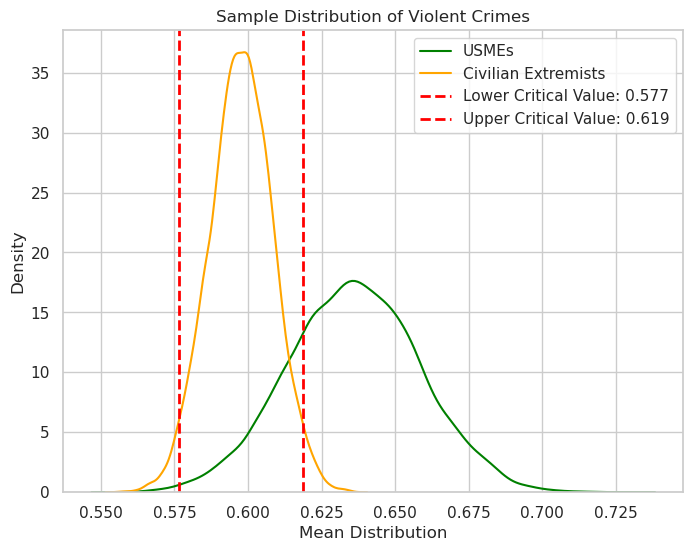

In [24]:
# plt.hist(practice, color="blue")

plt.figure(figsize=(8,6))
sns.set(style='whitegrid')

#Plot the KDE plots

# sns.kdeplot(violent_mil.squeeze(), color="red", palette="viridis")
sns.kdeplot(practice_mil, color="green", label="USMEs")
# sns.kdeplot(violent_civ, color="green", palette="viridis")
sns.kdeplot(practice_civ, color="orange", label="Civilian Extremists")
plt.axvline(critical_value, color='red', linestyle='dashed',
 linewidth=2, label=f'Lower Critical Value: {critical_value:.3f}')
plt.axvline(critical_value2, color='red', linestyle='dashed',
 linewidth=2, label=f'Upper Critical Value: {critical_value2:.3f}')
plt.title("Sample Distribution of Violent Crimes")
plt.xlabel("Mean Distribution")
plt.legend()


In [25]:
violent_mil.sample(10, replace=True).mean().iloc[0]

0.7

(array([  25.,  124.,  677., 1538., 2855., 2732., 1408.,  532.,   97.,
          12.]),
 array([0.55531915, 0.57170213, 0.58808511, 0.60446809, 0.62085106,
        0.63723404, 0.65361702, 0.67      , 0.68638298, 0.70276596,
        0.71914894]),
 <BarContainer object of 10 artists>)

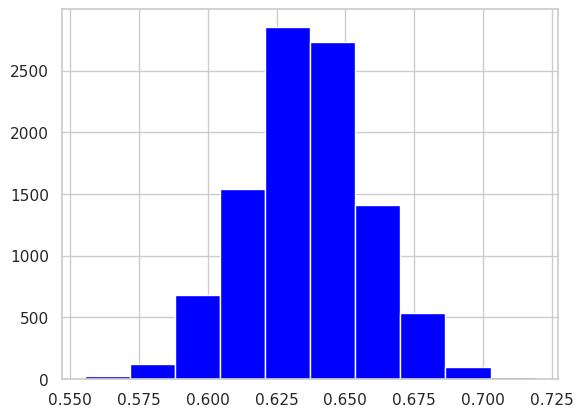

In [26]:
sample_means = []
for i in range(10000):
  sample_means.append(np.mean(np.random.choice(violent_mil.squeeze(), size=470, replace=True)))
# print(sample_means)

plt.hist(sample_means, color="blue")


## Convert Values

In [27]:
#mil_only
#civ_only
print(mil_only.columns.values)
mil_only.head()

['Violent' 'Group_Membership' 'Internet_Radicalization' 'Age'
 'Marital_Status' 'Children' 'Gender' 'Religious_Background' 'Education'
 'Military' 'Psychological' 'Alcohol_Drug' 'Previous_Criminal_Activity'
 'Angry_US' 'Group_Grievance']


,Violent,Group_Membership,Internet_Radicalization,Age,Marital_Status,Children,Gender,Religious_Background,Education,Military,Psychological,Alcohol_Drug,Previous_Criminal_Activity,Angry_US,Group_Grievance
6,0,3,1,32,1,0,2,15,6,1,2,1,0,1,0
20,0,3,1,52,3,2,2,-99,3,1,2,1,1,1,0
22,1,3,1,39,2,4,2,-99,-99,1,2,0,1,1,0
23,1,3,1,41,1,-99,2,-99,-99,1,0,0,0,0,0
34,0,3,1,35,2,0,1,-99,3,1,0,0,1,1,0


In [28]:
# Converting values to make proper logistic regression

# violent is already binary
Group_Membership_vals = {
  0: "no group", 
  1: "activist group",
  2: "informal extremists group",
  3: "formal extremist group",
  -99: "NO INFO"
}


In [29]:
functions.value_change(setup_df, "Group_Membership", Group_Membership_vals, "Group Membership")

setup_df.head()

,Violent,Internet_Radicalization,Age,Marital_Status,Children,Gender,Religious_Background,Education,Military,Psychological,Alcohol_Drug,Previous_Criminal_Activity,Angry_US,Group_Grievance,Group Membership
0,1,0,32,2,2,2,8,2,0,0,0,3,0,0,formal extremist group
1,0,1,20,1,0,2,8,3,0,0,0,0,1,-99,formal extremist group
2,1,1,28,2,1,2,11,3,0,0,0,3,1,1,formal extremist group
3,1,-88,25,2,1,2,5,5,0,0,0,0,1,2,informal extremists group
4,1,-88,25,1,0,2,5,5,0,0,0,-99,1,-99,informal extremists group


In [30]:
#What role did internet play in radicalization?
Internet_Radicalization_vals = {
  0: "no role",
  1: "not primary",
  2: "primary",
  -99: "NO INFO",
  -88: "NO INFO"
}

In [31]:
functions.value_change(setup_df, "Internet_Radicalization", Internet_Radicalization_vals, "Internet Radicalization")

setup_df.head()

,Violent,Age,Marital_Status,Children,Gender,Religious_Background,Education,Military,Psychological,Alcohol_Drug,Previous_Criminal_Activity,Angry_US,Group_Grievance,Group Membership,Internet Radicalization
0,1,32,2,2,2,8,2,0,0,0,3,0,0,formal extremist group,no role
1,0,20,1,0,2,8,3,0,0,0,0,1,-99,formal extremist group,not primary
2,1,28,2,1,2,11,3,0,0,0,3,1,1,formal extremist group,not primary
3,1,25,2,1,2,5,5,0,0,0,0,1,2,informal extremists group,NO INFO
4,1,25,1,0,2,5,5,0,0,0,-99,1,-99,informal extremists group,NO INFO


In [32]:
#Skipping age; already numerical
#What was their marital status?
Marital_Status_vals = {
  1: "single",
  2: "married",
  3: "divorce/separated",
  4: "widowed",
  -99: "NO INFO"
}

In [33]:
functions.value_change(setup_df, "Marital_Status", Marital_Status_vals, "Marital Status")

setup_df.head()

,Violent,Age,Children,Gender,Religious_Background,Education,Military,Psychological,Alcohol_Drug,Previous_Criminal_Activity,Angry_US,Group_Grievance,Group Membership,Internet Radicalization,Marital Status
0,1,32,2,2,8,2,0,0,0,3,0,0,formal extremist group,no role,married
1,0,20,0,2,8,3,0,0,0,0,1,-99,formal extremist group,not primary,single
2,1,28,1,2,11,3,0,0,0,3,1,1,formal extremist group,not primary,married
3,1,25,1,2,5,5,0,0,0,0,1,2,informal extremists group,NO INFO,married
4,1,25,0,2,5,5,0,0,0,-99,1,-99,informal extremists group,NO INFO,single


In [34]:
#Skipping children; already numerical
#What is their gender?
Gender_vals = {
  1: "female",
  2: "male",
  3: "non-binary",
  -99: "NO INFO"
}


In [35]:
functions.value_change(setup_df, "Gender", Gender_vals, "Sex")

setup_df.head()

,Violent,Age,Children,Religious_Background,Education,Military,Psychological,Alcohol_Drug,Previous_Criminal_Activity,Angry_US,Group_Grievance,Group Membership,Internet Radicalization,Marital Status,Sex
0,1,32,2,8,2,0,0,0,3,0,0,formal extremist group,no role,married,male
1,0,20,0,8,3,0,0,0,0,1,-99,formal extremist group,not primary,single,male
2,1,28,1,11,3,0,0,0,3,1,1,formal extremist group,not primary,married,male
3,1,25,1,5,5,0,0,0,0,1,2,informal extremists group,NO INFO,married,male
4,1,25,0,5,5,0,0,0,-99,1,-99,informal extremists group,NO INFO,single,male


In [36]:
#What is their religious background?
Religious_Background_vals = {
  1 : "Islam",
  2 : "Islam",
  3 : "Islam",
  4 : "Islam",
  5 : "Islam",
  6 : "Christianity",
  7 : "Christianity",
  8 : "Christianity",
  9 : "Christianity",
  10 : "Christianity",
  11 : "Christianity",
  12 : "Jewish",
  13 : "BuddhisT",
  14 : "Hindu",
  15 : "New religion",
  16 : "Agnostic",
  17 : "Atheist",
  18 : "Other",
  -99 : "NO INFO"
}

In [37]:
functions.value_change(setup_df, "Religious_Background", Religious_Background_vals, "Religious Background")

setup_df.head()

,Violent,Age,Children,Education,Military,Psychological,Alcohol_Drug,Previous_Criminal_Activity,Angry_US,Group_Grievance,Group Membership,Internet Radicalization,Marital Status,Sex,Religious Background
0,1,32,2,2,0,0,0,3,0,0,formal extremist group,no role,married,male,Christianity
1,0,20,0,3,0,0,0,0,1,-99,formal extremist group,not primary,single,male,Christianity
2,1,28,1,3,0,0,0,3,1,1,formal extremist group,not primary,married,male,Christianity
3,1,25,1,5,0,0,0,0,1,2,informal extremists group,NO INFO,married,male,Islam
4,1,25,0,5,0,0,0,-99,1,-99,informal extremists group,NO INFO,single,male,Islam


In [38]:
#Highest education completed?
Education_vals = {
  1 : "No high school",  
  2 : "Some high school",  
  3 : "High school diploma",  
  4 : "Some College",  
  5 : "College degree",  
  6 : "Some Vocational school",  
  7 : "Vocational school degree",  
  8 : "Some Masters school",  
  9 : "Masters degree",
  10 : "Some Doctoral",  
  11 : "Doctoral"
}


In [39]:
functions.value_change(setup_df, "Education", Education_vals, "Education_Level")

setup_df.head()

,Violent,Age,Children,Military,Psychological,Alcohol_Drug,Previous_Criminal_Activity,Angry_US,Group_Grievance,Group Membership,Internet Radicalization,Marital Status,Sex,Religious Background,Education_Level
0,1,32,2,0,0,0,3,0,0,formal extremist group,no role,married,male,Christianity,Some high school
1,0,20,0,0,0,0,0,1,-99,formal extremist group,not primary,single,male,Christianity,High school diploma
2,1,28,1,0,0,0,3,1,1,formal extremist group,not primary,married,male,Christianity,High school diploma
3,1,25,1,0,0,0,0,1,2,informal extremists group,NO INFO,married,male,Islam,College degree
4,1,25,0,0,0,0,-99,1,-99,informal extremists group,NO INFO,single,male,Islam,College degree


In [40]:
#Skipping Military bc thats what I'm dividing the samples by
#Is there evidenc of mental illness
Psychological_vals = {
  0 : "no",
  1 : "yes",
  2 : "yes"
}

In [41]:
functions.value_change(setup_df, "Psychological", Psychological_vals, "Mental Illness")

setup_df.head()

,Violent,Age,Children,Military,Alcohol_Drug,Previous_Criminal_Activity,Angry_US,Group_Grievance,Group Membership,Internet Radicalization,Marital Status,Sex,Religious Background,Education_Level,Mental Illness
0,1,32,2,0,0,3,0,0,formal extremist group,no role,married,male,Christianity,Some high school,no
1,0,20,0,0,0,0,1,-99,formal extremist group,not primary,single,male,Christianity,High school diploma,no
2,1,28,1,0,0,3,1,1,formal extremist group,not primary,married,male,Christianity,High school diploma,no
3,1,25,1,0,0,0,1,2,informal extremists group,NO INFO,married,male,Islam,College degree,no
4,1,25,0,0,0,-99,1,-99,informal extremists group,NO INFO,single,male,Islam,College degree,no


In [42]:
#Skipping Alcohol_Drug because it's binary
#History of non ideological related criminal activity?
Previous_Criminal_Activity_vals = {
  0 : "no",  
  1 : "minor",  
  2 : "serious", 
  3 : "violent",  
  -99 : "NO INFO"
}

In [43]:
functions.value_change(setup_df, "Previous_Criminal_Activity", Previous_Criminal_Activity_vals, "Criminal History")

setup_df.head()

,Violent,Age,Children,Military,Alcohol_Drug,Angry_US,Group_Grievance,Group Membership,Internet Radicalization,Marital Status,Sex,Religious Background,Education_Level,Mental Illness,Criminal History
0,1,32,2,0,0,0,0,formal extremist group,no role,married,male,Christianity,Some high school,no,violent
1,0,20,0,0,0,1,-99,formal extremist group,not primary,single,male,Christianity,High school diploma,no,no
2,1,28,1,0,0,1,1,formal extremist group,not primary,married,male,Christianity,High school diploma,no,violent
3,1,25,1,0,0,1,2,informal extremists group,NO INFO,married,male,Islam,College degree,no,no
4,1,25,0,0,0,1,-99,informal extremists group,NO INFO,single,male,Islam,College degree,no,NO INFO


In [44]:
#Is there evidence that this person was Angry with US society?
Angry_US_vals = {
  0 : "no",
  1 : "yes",
  -99 :"NO INFO"
}

In [45]:
functions.value_change(setup_df, "Angry_US", Angry_US_vals, "Angry US")

setup_df.head()

,Violent,Age,Children,Military,Alcohol_Drug,Group_Grievance,Group Membership,Internet Radicalization,Marital Status,Sex,Religious Background,Education_Level,Mental Illness,Criminal History,Angry US
0,1,32,2,0,0,0,formal extremist group,no role,married,male,Christianity,Some high school,no,violent,no
1,0,20,0,0,0,-99,formal extremist group,not primary,single,male,Christianity,High school diploma,no,no,yes
2,1,28,1,0,0,1,formal extremist group,not primary,married,male,Christianity,High school diploma,no,violent,yes
3,1,25,1,0,0,2,informal extremists group,NO INFO,married,male,Islam,College degree,no,no,yes
4,1,25,0,0,0,-99,informal extremists group,NO INFO,single,male,Islam,College degree,no,NO INFO,yes


In [46]:
#Did they identify with a group they believed was marginalized?

Group_Grievance_vals = {
  0 : "no",  
  1 : "yes",  
  2 : "yes",  
  3 : "yes",  
  -99 : "NO INFO"
}

In [47]:
functions.value_change(setup_df, "Group_Grievance", Group_Grievance_vals, "Group Grievance")

setup_df.head()

,Violent,Age,Children,Military,Alcohol_Drug,Group Membership,Internet Radicalization,Marital Status,Sex,Religious Background,Education_Level,Mental Illness,Criminal History,Angry US,Group Grievance
0,1,32,2,0,0,formal extremist group,no role,married,male,Christianity,Some high school,no,violent,no,no
1,0,20,0,0,0,formal extremist group,not primary,single,male,Christianity,High school diploma,no,no,yes,NO INFO
2,1,28,1,0,0,formal extremist group,not primary,married,male,Christianity,High school diploma,no,violent,yes,yes
3,1,25,1,0,0,informal extremists group,NO INFO,married,male,Islam,College degree,no,no,yes,yes
4,1,25,0,0,0,informal extremists group,NO INFO,single,male,Islam,College degree,no,NO INFO,yes,NO INFO


In [48]:
setup_df.shape

(3203, 15)

In [49]:
#Delete rows with UNK age because it would skew data
setup_df = setup_df[setup_df["Age"] != -99]
setup_df[setup_df["Age"] == -99].value_counts().sum()

0

In [50]:
setup_df.shape

(3106, 15)

In [51]:
setup_df[setup_df["Children"] == 0].value_counts().sum()

806

In [52]:
#Changing rows with UNK children to have 0 children because it would skew data
setup_df["Children"].replace(-99, 0, inplace=True)
setup_df[setup_df["Children"] == -99].value_counts().sum()

0

In [53]:
setup_df[setup_df["Children"] == 0].value_counts().sum()

1030

In [54]:
#Splitting DF into military and civillians
mil_only = setup_df[setup_df["Military"] == 1]

civ_only = setup_df[setup_df["Military"] == 0]

## Make Dummies

In [55]:
#Check for columns to make dummies out of
setup_df.columns.values

array(['Violent', 'Age', 'Children', 'Military', 'Alcohol_Drug',
       'Group Membership', 'Internet Radicalization', 'Marital Status',
       'Sex', 'Religious Background', 'Education_Level', 'Mental Illness',
       'Criminal History', 'Angry US', 'Group Grievance'], dtype=object)

In [56]:
# Make Dummies
setup_dummies = pd.get_dummies(setup_df, columns=['Group Membership', 'Internet Radicalization', 'Marital Status',
       'Sex', 'Religious Background', 'Education_Level', 'Mental Illness',
       'Criminal History', 'Angry US', 'Group Grievance'])

setup_dummies.head()

,Violent,Age,Children,Military,Alcohol_Drug,Group Membership_NO INFO,Group Membership_activist group,Group Membership_formal extremist group,Group Membership_informal extremists group,Group Membership_no group,...,Criminal History_minor,Criminal History_no,Criminal History_serious,Criminal History_violent,Angry US_NO INFO,Angry US_no,Angry US_yes,Group Grievance_NO INFO,Group Grievance_no,Group Grievance_yes
0,1,32,2,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,1,0
1,0,20,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,1,0,0
2,1,28,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,1
3,1,25,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,1
4,1,25,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0


In [57]:
#Drop the no info columns
setup_dummies.columns.values.reshape(-1,1)
setup_dummies.drop(columns=['Group Membership_NO INFO', 'Internet Radicalization_NO INFO',
                             'Marital Status_NO INFO', 'Religious Background_NO INFO',
                             'Criminal History_NO INFO', 'Angry US_NO INFO', 'Group Grievance_NO INFO'], inplace=True)

## Make the Logistic Regression 

In [153]:
# Make Logistic Regression for mil only
mil_dummies = setup_dummies[setup_dummies["Military"] == 1]
mil_dummies.head()

,Violent,Age,Children,Military,Alcohol_Drug,Group Membership_activist group,Group Membership_formal extremist group,Group Membership_informal extremists group,Group Membership_no group,Internet Radicalization_no role,...,Mental Illness_no,Mental Illness_yes,Criminal History_minor,Criminal History_no,Criminal History_serious,Criminal History_violent,Angry US_no,Angry US_yes,Group Grievance_no,Group Grievance_yes
6,0,32,0,1,1,0,1,0,0,0,...,0,1,0,1,0,0,0,1,1,0
20,0,52,2,1,1,0,1,0,0,0,...,0,1,1,0,0,0,0,1,1,0
22,1,39,4,1,0,0,1,0,0,0,...,0,1,1,0,0,0,0,1,1,0
23,1,41,0,1,0,0,1,0,0,0,...,1,0,0,1,0,0,1,0,1,0
34,0,35,0,1,0,0,1,0,0,0,...,1,0,1,0,0,0,0,1,1,0


In [154]:
mil_X = mil_dummies.drop(columns="Violent")
mil_y = mil_dummies["Violent"]

X_train, X_test, y_train, y_test = train_test_split(mil_X, mil_y, test_size=0.25, random_state=99)

In [155]:
#instantiate model
#Why did I do it here?

log_model = LogisticRegression()

log_model.fit(X_train, y_train)

kf = KFold()

In [156]:
#Log predictions
predict = log_model.predict(X_test.values)
probs = log_model.predict_proba(X_test.values)

print("predict:\n", predict)
print("\nProbability:\n", probs)

predict:
 [1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1
 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 1
 1 0 0 1 1 1]

Probability:
 [[0.42784819 0.57215181]
 [0.87556137 0.12443863]
 [0.0815833  0.9184167 ]
 [0.08875376 0.91124624]
 [0.51137449 0.48862551]
 [0.10067735 0.89932265]
 [0.05049942 0.94950058]
 [0.31556582 0.68443418]
 [0.25700561 0.74299439]
 [0.67350006 0.32649994]
 [0.03869234 0.96130766]
 [0.15007814 0.84992186]
 [0.72315822 0.27684178]
 [0.09297809 0.90702191]
 [0.24366797 0.75633203]
 [0.4924314  0.5075686 ]
 [0.59229664 0.40770336]
 [0.03561072 0.96438928]
 [0.40111529 0.59888471]
 [0.16534145 0.83465855]
 [0.32972702 0.67027298]
 [0.26555075 0.73444925]
 [0.39434996 0.60565004]
 [0.17189456 0.82810544]
 [0.13347055 0.86652945]
 [0.34685536 0.65314464]
 [0.45748358 0.54251642]
 [0.05113427 0.94886573]
 [0.26434624 0.73565376]
 [0.3060138

In [157]:

pred = [1 if i > 0.5 else 0 for i in probs[:, 1]]
pred

[1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1]

In [158]:
conf_matrix = confusion_matrix(y_test, pred)
conf_matrix

array([[14, 29],
       [16, 58]])

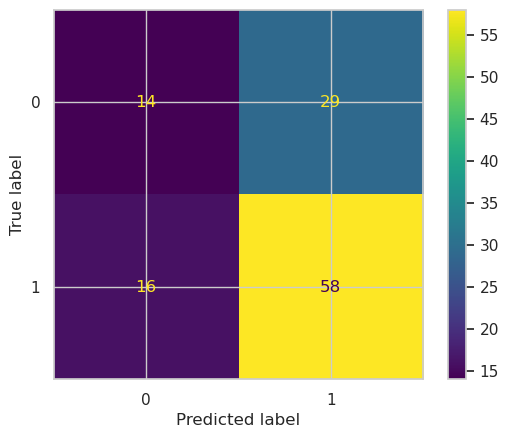

In [159]:
display_conf_matrix = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=log_model.classes_)
display_conf_matrix.plot()

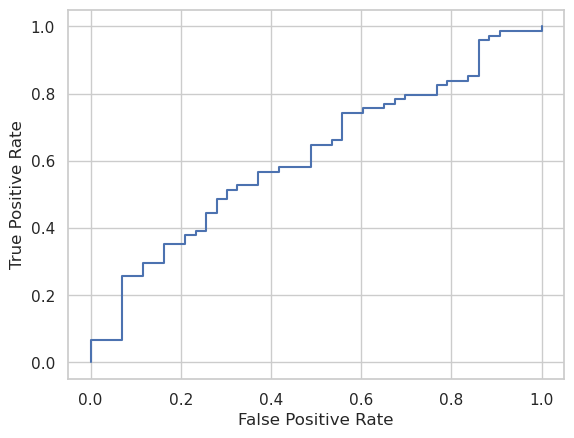

In [160]:
false_pos_rate, true_pos_rate, x = roc_curve(y_test, probs[:, 1])
roc_auc = auc(false_pos_rate, true_pos_rate)

roc_display = RocCurveDisplay(fpr=false_pos_rate, tpr=true_pos_rate, roc_auc=roc_auc)

plt.plot(false_pos_rate, true_pos_rate)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [161]:
# Checking Coefficients
coeff = pd.DataFrame({'Column Name': mil_X.columns.values, 'Coefficients': log_model.coef_.reshape(-1)})

coeff

,Column Name,Coefficients
0,Age,0.010229
1,Children,-0.034549
2,Military,0.090339
3,Alcohol_Drug,0.172901
4,Group Membership_activist group,-0.889047
5,Group Membership_formal extremist group,0.072503
6,Group Membership_informal extremists group,0.408964
7,Group Membership_no group,0.460564
8,Internet Radicalization_no role,0.037404
9,Internet Radicalization_not primary,-0.293369


#### MIL Test Log Model

In [162]:
mil_accuracy_scores = cross_val_score(log_model, X_test, y_test, cv=kf, scoring='accuracy') #How accuate the model is overall
mil_precision_scores = cross_val_score(log_model, X_test, y_test, cv=kf, scoring='precision') #Accurately predicting true positive
mil_recall_scores = cross_val_score(log_model, X_test, y_test, cv=kf, scoring='recall') #Accurately predicting false negative

print("Accuracy: \n", mil_accuracy_scores.mean())
print("Precision: \n", mil_precision_scores.mean())
print("Recall: \n", mil_recall_scores.mean())

Accuracy: 
 0.5289855072463768
Precision: 
 0.6172619047619048
Recall: 
 0.755


### Normalized Mil Log Model (The Better Model)

In [163]:
#standardize x data
X_train, X_test, y_train, y_test = train_test_split(mil_X, mil_y, test_size=0.25, random_state=99)
mil_stan = MinMaxScaler()
X_train[["Age", "Children"]] = mil_stan.fit_transform(X_train[["Age", "Children"]])
X_test[["Age", "Children"]] = mil_stan.transform(X_test[["Age", "Children"]])



In [164]:
#Checking results
X_test


,Age,Children,Military,Alcohol_Drug,Group Membership_activist group,Group Membership_formal extremist group,Group Membership_informal extremists group,Group Membership_no group,Internet Radicalization_no role,Internet Radicalization_not primary,...,Mental Illness_no,Mental Illness_yes,Criminal History_minor,Criminal History_no,Criminal History_serious,Criminal History_violent,Angry US_no,Angry US_yes,Group Grievance_no,Group Grievance_yes
1552,0.262295,0.000000,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
639,0.311475,0.266667,1,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,1,1,0
2674,0.622951,0.000000,1,0,0,0,1,0,0,0,...,0,1,1,0,0,0,0,1,0,0
2576,0.311475,0.000000,1,1,0,0,0,1,0,1,...,0,1,0,0,0,1,0,1,1,0
1267,0.163934,0.000000,1,0,0,1,0,0,0,0,...,1,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1415,0.590164,0.266667,1,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1
802,0.360656,0.133333,1,1,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
1202,0.262295,0.000000,1,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
935,0.327869,0.000000,1,0,0,1,0,0,0,1,...,1,0,0,0,0,0,1,0,1,0


In [165]:

log_stan_model = LogisticRegression()
log_stan_model.fit(X_train, y_train)

kf = KFold()

mil_stan_accuracy_scores = cross_val_score(log_stan_model, X_test, y_test, cv=kf, scoring='accuracy') #How many predictions were correct
mil_stan_precision_scores = cross_val_score(log_stan_model, X_test, y_test, cv=kf, scoring='precision') #How many positive predictions were correct
mil_stan_recall_scores = cross_val_score(log_stan_model, X_test, y_test, cv=kf, scoring='recall') #How many positive predictions were made

print("Accuracy: \n", mil_stan_accuracy_scores.mean())
print("Precision: \n", mil_stan_precision_scores.mean())
print("Recall: \n", mil_stan_recall_scores.mean())

Accuracy: 
 0.5293478260869564
Precision: 
 0.6169117647058824
Recall: 
 0.7683333333333333


In [166]:
#Log prediction estimates??
predict = log_model.predict(X_test.values)

# log_predict = log_model.predict_log_proba(X_test.values)

probs = log_model.predict_proba(X_test.values)
print("predict:\n", predict)
# print("\nlog_predict:\n", log_predict)
print("\nProbability:\n", probs)



predict:
 [0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1
 1 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 0 1 0 0 0 1
 1 0 0 1 1 1]

Probability:
 [[0.51617137 0.48382863]
 [0.90092974 0.09907026]
 [0.13654043 0.86345957]
 [0.12527279 0.87472721]
 [0.58430709 0.41569291]
 [0.14380145 0.85619855]
 [0.06125174 0.93874826]
 [0.36360662 0.63639338]
 [0.38824262 0.61175738]
 [0.73674022 0.26325978]
 [0.05277526 0.94722474]
 [0.22482244 0.77517756]
 [0.77956903 0.22043097]
 [0.14557764 0.85442236]
 [0.34377225 0.65622775]
 [0.58789065 0.41210935]
 [0.74013353 0.25986647]
 [0.05939045 0.94060955]
 [0.501208   0.498792  ]
 [0.1936113  0.8063887 ]
 [0.4668687  0.5331313 ]
 [0.33579405 0.66420595]
 [0.46652776 0.53347224]
 [0.20556996 0.79443004]
 [0.15759165 0.84240835]
 [0.45883075 0.54116925]
 [0.57088998 0.42911002]
 [0.06427159 0.93572841]
 [0.37489087 0.62510913]
 [0.3556535

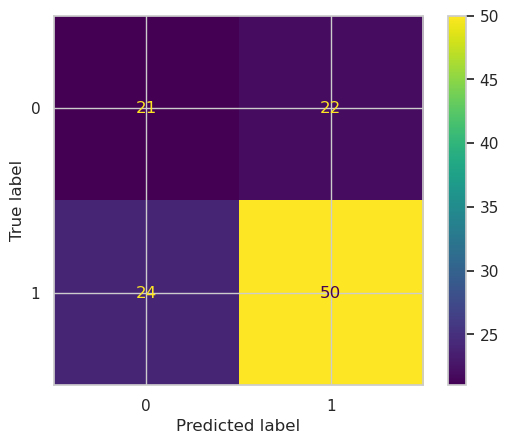

In [167]:

pred = [1 if i > 0.5 else 0 for i in probs[:, 1]]
pred
conf_matrix = confusion_matrix(y_test, pred)
conf_matrix
display_conf_matrix = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=log_model.classes_)
display_conf_matrix.plot()

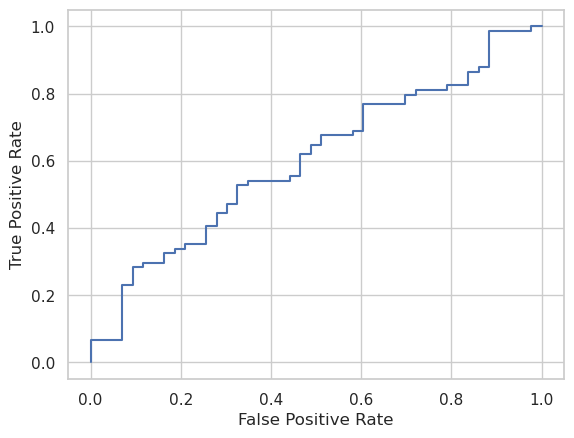

In [168]:
false_pos_rate, true_pos_rate, x = roc_curve(y_test, probs[:, 1])
roc_auc = auc(false_pos_rate, true_pos_rate)

roc_display = RocCurveDisplay(fpr=false_pos_rate, tpr=true_pos_rate, roc_auc=roc_auc)

plt.plot(false_pos_rate, true_pos_rate)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Making Civ Log Model

In [169]:
# Make Logistic Regression for civ only
civ_dummies = setup_dummies[setup_dummies["Military"] == 0]
civ_dummies.head()

,Violent,Age,Children,Military,Alcohol_Drug,Group Membership_activist group,Group Membership_formal extremist group,Group Membership_informal extremists group,Group Membership_no group,Internet Radicalization_no role,...,Mental Illness_no,Mental Illness_yes,Criminal History_minor,Criminal History_no,Criminal History_serious,Criminal History_violent,Angry US_no,Angry US_yes,Group Grievance_no,Group Grievance_yes
0,1,32,2,0,0,0,1,0,0,1,...,1,0,0,0,0,1,1,0,1,0
1,0,20,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,1,0,0
2,1,28,1,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0,1,0,1
3,1,25,1,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,1
4,1,25,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0


In [170]:
civ_X = civ_dummies.drop(columns="Violent")
civ_y = civ_dummies["Violent"]

X_train, X_test, y_train, y_test = train_test_split(civ_X, civ_y, test_size=0.25, random_state=99)

In [171]:
#instantiate model

log_model = LogisticRegression()

log_model.fit(X_train, y_train)

kf = KFold()

### Civ Test Log Model

In [172]:
civ_accuracy_scores = cross_val_score(log_model, X_test, y_test, cv=kf, scoring='accuracy') #How accuate the model is overall
civ_precision_scores = cross_val_score(log_model, X_test, y_test, cv=kf, scoring='precision') #Accurately predicting true positive
civ_recall_scores = cross_val_score(log_model, X_test, y_test, cv=kf, scoring='recall') #Accurately predicting false negative

print("Accuracy: \n", civ_accuracy_scores.mean())
print("Precision: \n", civ_precision_scores.mean())
print("Recall: \n", civ_recall_scores.mean())

Accuracy: 
 0.6222554144884243
Precision: 
 0.6570844388971978
Recall: 
 0.7565666843758965


##### Civ Confusion Matrix

In [173]:
#Log prediction estimates??
predict = log_model.predict(X_test.values)

# log_predict = log_model.predict_log_proba(X_test.values)

probs = log_model.predict_proba(X_test.values)
print("predict:\n", predict)
# print("\nlog_predict:\n", log_predict)
print("\nProbability:\n", probs)



predict:
 [1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1
 0 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0
 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 0
 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1
 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 0 0 1 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 0 1 1 0 0 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0
 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 0 1 1 0 1 1 1
 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1
 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0
 1 1 1 0 1 1 0 

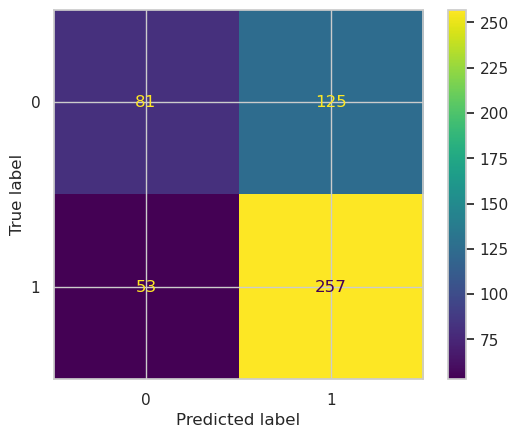

In [174]:

pred = [1 if i > 0.5 else 0 for i in probs[:, 1]]
pred
conf_matrix = confusion_matrix(y_test, pred)
conf_matrix
display_conf_matrix = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=log_model.classes_)
display_conf_matrix.plot()

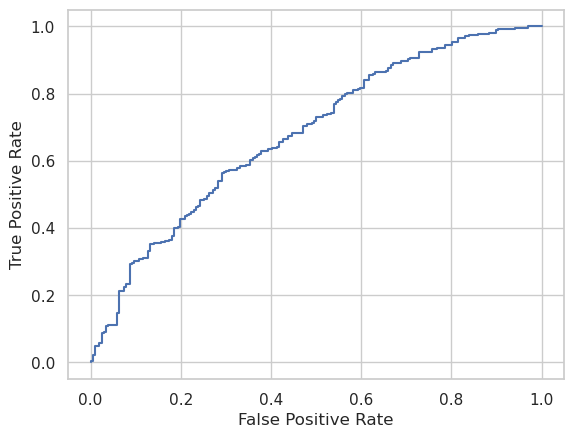

In [175]:
false_pos_rate, true_pos_rate, x = roc_curve(y_test, probs[:, 1])
roc_auc = auc(false_pos_rate, true_pos_rate)

roc_display = RocCurveDisplay(fpr=false_pos_rate, tpr=true_pos_rate, roc_auc=roc_auc)

plt.plot(false_pos_rate, true_pos_rate)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Did not Normalize Civ Data because it was a LESS ACCURATE Model